In [1]:
"""  
Spectrum Instrumentation GmbH (c) 2024

1_dds_single_static_carrier.py

Single static carrier - This example shows the DDS functionality with 1 carrier with a fixed frequency and fixed amplitude

Example for analog replay cards (AWG) for the the M4i and M4x card-families with installed DDS option.

See the README file in the parent folder of this examples directory for information about how to use this example.

See the LICENSE file for the conditions under which this software may be used and distributed.
"""

import spcm
from spcm import units

card : spcm.Card
# with spcm.Card('/dev/spcm0') as card:                         # if you want to open a specific card
# with spcm.Card('TCPIP::192.168.1.10::inst0::INSTR') as card:  # if you want to open a remote card
# with spcm.Card(serial_number=12345) as card:                  # if you want to open a card by its serial number
with spcm.Card(card_type=spcm.SPCM_TYPE_AO) as card:             # if you want to open the first card of a specific type

    # setup card for DDS
    card.card_mode(spcm.SPC_REP_STD_DDS)

    # Setup the channels
    channels = spcm.Channels(card, card_enable=spcm.CHANNEL0)
    channels[0].enable(True)
    channels[0].output_load(50 * units.ohm)
    channels[0].amp(0.5 * units.V)
    card.write_setup() # IMPORTANT! this turns on the card's system clock signals, that are required for DDS to work
    
    # Setup DDS functionality
    dds = spcm.DDS(card, channels=channels)
    dds.reset()

    # Start the test
    # dds[0].amp(-20 * units.dBm)
    dds[0].amp(100 * units.mV)
    dds[0].freq(10 * units.MHz)
    dds[0].phase(20 * units.degrees)
    # Read back the exact frequency
    freq = dds[0].get_freq(return_unit=units.MHz)
    amp = dds[0].get_amp(return_unit=units.dBm)
    phase = dds[0].get_phase(return_unit=units.rad)
    print(f"Generated signal frequency: {freq} and amplitude: {amp} and phase: {phase}")
    
    dds.exec_at_trg()
    dds.write_to_card()

    # Start command including enable of trigger engine
    card.start(spcm.M2CMD_CARD_ENABLETRIGGER, spcm.M2CMD_CARD_FORCETRIGGER)

    input("Press Enter to Exit")


Generated signal frequency: 9.999999892897904 MHz and amplitude: -10.000530176990829 dBm and phase: 0.34907650304322624 rad


Program beginning time: 2025-09-24 16:04:45


c:\Users\a\.conda\envs\AWG_control\Lib\site-packages\matplotlib\cbook.py:1355: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


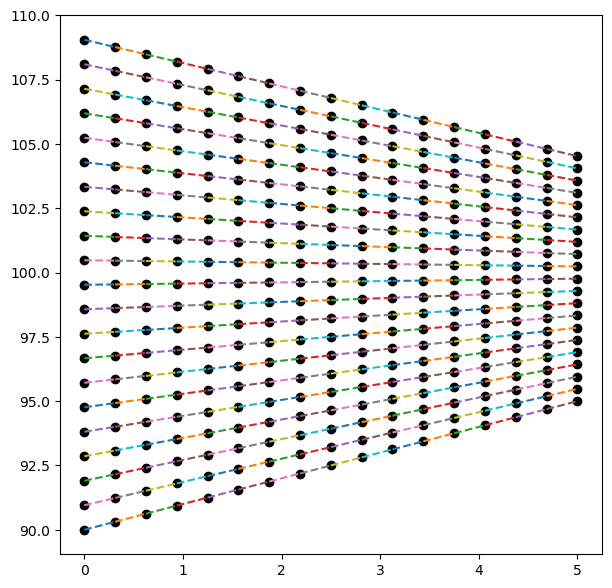


Program ending time: 2025-09-24 16:04:47
Total time: 2.4664 秒


In [ ]:
import spcm,time
from spcm import units
import numpy as np
import matplotlib.pyplot as plt


def shape_linear(x):
    return x

def shape_cosine(x):
    return 0.5-0.5*np.cos(np.pi*x)

def shape_square(x):
    return np.where(x < 0.5, 0, 1)

# record the beginning time of the program  
start_time = time.time()
print(f"Program beginning time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")

def calculate_slopes_for_given_shape(parameters,shape):
    frequency_range_Hz = parameters["endFreq_Hz"] - parameters["startFreq_Hz"]                      
    unit_slices_in = np.linspace(0, 1, num_segments+1, endpoint=True)
    unit_slices_out = shape(unit_slices_in)
    time_list = unit_slices_in*parameters["time_s"]         
    output_list = unit_slices_out*frequency_range_Hz+parameters["startFreq_Hz"]         
    t_diff = np.diff(time_list)
    y_diff = np.diff(output_list)
    return np.divide(y_diff, t_diff),time_list,output_list  


card : spcm.Card
with spcm.Card('/dev/spcm0') as card:       
    card.card_mode(spcm.SPC_REP_STD_DDS)    # setup card for DDS
    channels = spcm.Channels(card)
    channels.enable(True)
    channels.amp(1 * units.V)
    card.write_setup() # IMPORTANT! this turns on the card's system clock signals, that are required for DDS to work
    dds = spcm.DDS(card)    # Setup DDS
    dds.reset()
    dds.data_transfer_mode(spcm.SPCM_DDS_DTM_DMA)
    num_cores = len(dds)     # Start the DDS test
    first_init_freq_Hz  = 90 * units.MHz    # 20 Carriers from 90 to 110 MHz
    delta_init_freq_Hz  = 20*1/num_cores * units.MHz
    first_final_freq_Hz = 95  * units.MHz    # to 20 Carriers from 95 to 105 MHz
    delta_final_freq_Hz = 10*1/num_cores * units.MHz 
    
    # Ramp settings
    num_segments = 16
    total_time_s = 5.0 * units.s
    ramp_type = 'cosine' # 'cosine' or 'square' or '3rd-order'


    dds.freq_ramp_stepsize(1000)      # STEP 0 - Initialize frequencies
    dds.trg_timer(15.0 * units.s)
    dds.trg_src(spcm.SPCM_DDS_TRG_SRC_TIMER)
    for core in dds:
        core.amp(45 * units.percent / num_cores)
        core.freq(first_init_freq_Hz + int(core) * delta_init_freq_Hz)
    dds.exec_at_trg()
    dds.write_to_card()


    period_s = total_time_s / num_segments # seconds      # STEP 1 - Start the ramp
    dds.trg_timer(period_s) # after 5.0 s stop the ramp
    
    parameters = []    # Define the parameters
    slopes = np.zeros((num_cores, num_segments))
    plt.figure(figsize=(7,7))    # Show the results
    for core in dds:
        parameters = {
            "startFreq_Hz": first_init_freq_Hz + core.index * delta_init_freq_Hz, 
            "endFreq_Hz": first_final_freq_Hz + core.index * delta_final_freq_Hz, 
            "time_s": total_time_s, 
            }

        sl_core,time_list,output_list = calculate_slopes_for_given_shape(parameters,shape_0)
        slopes[core, :] = sl_core.to_base_units().magnitude

        plt.plot(time_list, output_list, 'ok')
        t_fine_s = np.linspace(time_list[0], time_list[1], 2, endpoint=True)
        for j, sl in enumerate(sl_core):
            plt.plot(t_fine_s + time_list[j], output_list[j] + sl*(t_fine_s), '--')

    plt.show(block=False)

    # Do the slopes
    for j in range(num_segments):
        for core in dds:
            core.frequency_slope(slopes[core][j]) # Hz/s
        dds.exec_at_trg()

    # STEP 2 - Stop the ramp
    for core in dds:
        core.frequency_slope(0) # Hz/s
        core.freq(first_final_freq_Hz + core.index * delta_final_freq_Hz)
    dds.exec_at_trg()
    dds.write_to_card()

    # 记录程序结束时间并计算总运行时间
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"\nProgram ending time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
    print(f"Total time: {execution_time:.4f} 秒")